# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df

,Open
Date,
2020-06-01,0.94545
2020-06-02,1.01907
2020-06-03,0.95270
2020-06-04,0.96672
2020-06-05,0.97940
...,...
2022-05-28,2.86201
2022-05-29,2.90271
2022-05-30,2.94652


In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['Open'].values.reshape(-1, 1)
df.head()

df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [4]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = LR_sc.fit_transform(df_open)
df_scaled

,Open,Timestamp
Date,,
2020-06-01,-1.566754,1.590970e+09
2020-06-02,-1.522736,1.591056e+09
2020-06-03,-1.562419,1.591142e+09
2020-06-04,-1.554036,1.591229e+09
2020-06-05,-1.546455,1.591315e+09
...,...,...
2022-05-28,-0.420844,1.653696e+09
2022-05-29,-0.396509,1.653782e+09
2022-05-30,-0.370315,1.653869e+09


## Vẽ đồ thị

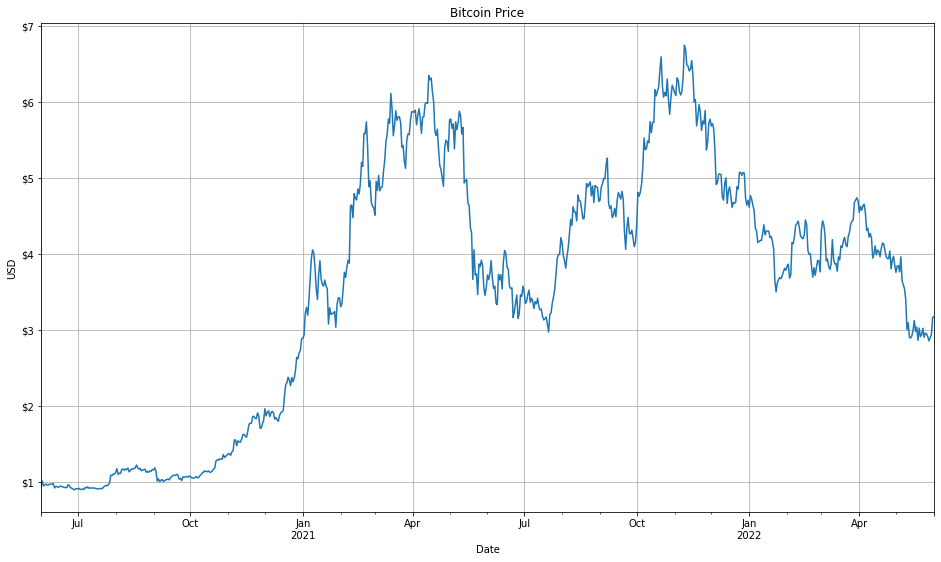

In [5]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [6]:
df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [7]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Open'] = y_scaled
df_scaled.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729683,-1.566754
2020-06-02,-1.724944,-1.522736
2020-06-03,-1.720205,-1.562419
2020-06-04,-1.715466,-1.554036
2020-06-05,-1.710728,-1.546455


## Chia tập dữ liệu

In [8]:
interrupt = int(len(df_scaled) * .9)
interrupt


657

In [9]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(657, 2)
(74, 2)


In [10]:
train_data.tail()

,Timestamp,Open
Date,,
2022-03-15,1.360052,0.240009
2022-03-16,1.364791,0.216661
2022-03-17,1.369530,0.326447
2022-03-18,1.374269,0.314244
2022-03-19,1.379008,0.365269


In [11]:
test_data.head()

,Timestamp,Open
Date,,
2022-03-20,1.383746,0.393549
2022-03-21,1.388485,0.336211
2022-03-22,1.393224,0.320665
2022-03-23,1.397963,0.401442
2022-03-24,1.402702,0.433609


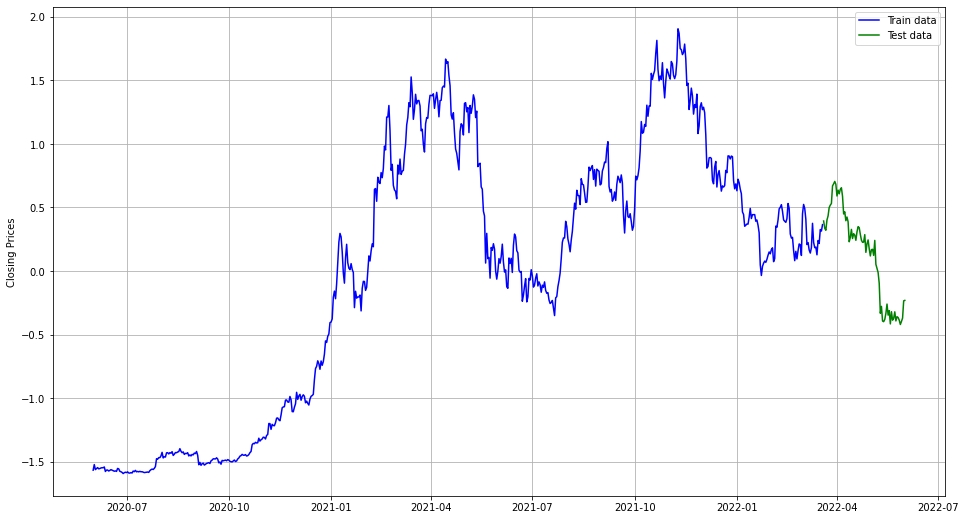

In [12]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Open'], 'blue', label='Train data')
plt.plot(test_data['Open'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Open




In [13]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Open'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Open'].values.reshape(-1, 1)


In [14]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [15]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

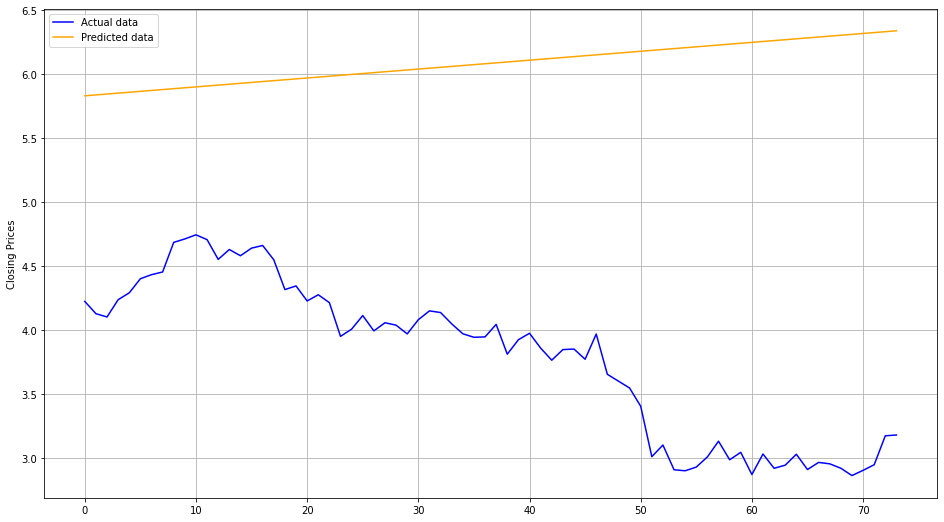

In [16]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [17]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.30
MAPE: 65.84%
MSE: 5.85
RMSE: 2.42
R2: -14.96


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [18]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2022-03-20,4.22410,5.832083,-1.607983
2022-03-21,4.12820,5.839046,-1.710846
2022-03-22,4.10220,5.846010,-1.743810
2022-03-23,4.23730,5.852973,-1.615673
2022-03-24,4.29110,5.859937,-1.568837
...,...,...,...
2022-05-28,2.86201,6.312565,-3.450555
2022-05-29,2.90271,6.319528,-3.416818
2022-05-30,2.94652,6.326492,-3.379972


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [19]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2022-03-20,4.22410,5.832083,-1.607983
2022-03-21,4.12820,5.839046,-1.710846
2022-03-22,4.10220,5.846010,-1.743810
2022-03-23,4.23730,5.852973,-1.615673
2022-03-24,4.29110,5.859937,-1.568837
...,...,...,...
2022-05-28,2.86201,6.312565,-3.450555
2022-05-29,2.90271,6.319528,-3.416818
2022-05-30,2.94652,6.326492,-3.379972


## Vẽ đồ thị thể hiện sai số

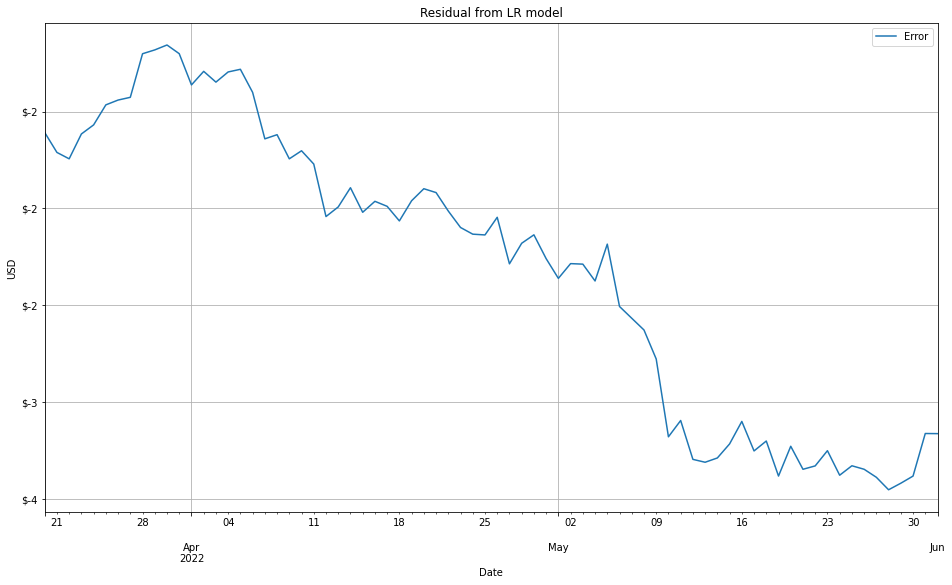

In [20]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [21]:
error = np.array(error)
error

array([[-1.60798276],
       [-1.71084626],
       [-1.74380977],
       [-1.61567328],
       [-1.56883678],
       [-1.46560029],
       [-1.4407638 ],
       [-1.4266273 ],
       [-1.20189081],
       [-1.18215432],
       [-1.15681782],
       [-1.20158133],
       [-1.36274484],
       [-1.29270834],
       [-1.34827185],
       [-1.29583536],
       [-1.28209886],
       [-1.40106237],
       [-1.64082588],
       [-1.61938938],
       [-1.74385289],
       [-1.7023164 ],
       [-1.7708799 ],
       [-2.04154341],
       [-1.99200692],
       [-1.89287042],
       [-2.01953393],
       [-1.96299744],
       [-1.98886095],
       [-2.06402445],
       [-1.96008796],
       [-1.89805147],
       [-1.91791497],
       [-2.01317848],
       [-2.09794199],
       [-2.13240549],
       [-2.136369  ],
       [-2.04543251],
       [-2.28539601],
       [-2.17935952],
       [-2.13582303],
       [-2.25858653],
       [-2.36035004],
       [-2.28431355],
       [-2.28697705],
       [-2

In [22]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (71, 3, 1)
y_train (71, 1)


In [23]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
3/3 [==============================] - 3s 7ms/step - loss: 5.7000
Epoch 2/300
3/3 [==============================] - 0s 10ms/step - loss: 5.5280
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 5.3541
Epoch 4/300
3/3 [==============================] - 0s 7ms/step - loss: 5.1525
Epoch 5/300
3/3 [==============================] - 0s 8ms/step - loss: 4.9362
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 4.6794
Epoch 7/300
3/3 [==============================] - 0s 10ms/step - loss: 4.3839
Epoch 8/300
3/3 [==============================] - 0s 7ms/step - loss: 4.0154
Epoch 9/300
3/3 [==============================] - 0s 7ms/step - loss: 3.5827
Epoch 10/300
3/3 [==============================] - 0s 7ms/step - loss: 3.0436
Epoch 11/300
3/3 [==============================] - 0s 6ms/step - loss: 2.3919
Epoch 12/300
3/3 [==============================] - 0s 7ms/step - loss: 1.6672
Epoch 13/300
3/3 [==============================] - 0s 7ms/

In [24]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[-1.7182925],
       [-1.7545854],
       [-1.7267467],
       [-1.6462417],
       [-1.5957558],
       [-1.5452452],
       [-1.5034174],
       [-1.4373535],
       [-1.3427795],
       [-1.3343775],
       [-1.3551093],
       [-1.4042218],
       [-1.4559021],
       [-1.4362744],
       [-1.4429029],
       [-1.4334701],
       [-1.4882485],
       [-1.5967134],
       [-1.7069035],
       [-1.7268641],
       [-1.7777869],
       [-1.815389 ],
       [-1.9170713],
       [-2.0117946],
       [-1.977172 ],
       [-1.96165  ],
       [-2.0063925],
       [-1.9986165],
       [-2.0184605],
       [-2.0133479],
       [-1.950079 ],
       [-1.9409744],
       [-1.9899342],
       [-2.0642123],
       [-2.115067 ],
       [-2.1196108],
       [-2.1278818],
       [-2.1433957],
       [-2.2193618],
       [-2.1723995],
       [-2.2044044],
       [-2.2851398],
       [-2.311516 ],
       [-2.287603 ],
       [-2.2886014],
       [-2.318299 ],
       [-2.336188 ],
       [-2.52

In [25]:
df_lstm

,Actual,Pred,Error
Date,,,
2022-03-20,4.22410,5.832083,-1.607983
2022-03-21,4.12820,5.839046,-1.710846
2022-03-22,4.10220,5.846010,-1.743810
2022-03-23,4.23730,5.852973,-1.615673
2022-03-24,4.29110,5.859937,-1.568837
...,...,...,...
2022-05-28,2.86201,6.312565,-3.450555
2022-05-29,2.90271,6.319528,-3.416818
2022-05-30,2.94652,6.326492,-3.379972


In [26]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2022-03-20,4.22410,5.832083,-1.607983,-1.718292
2022-03-21,4.12820,5.839046,-1.710846,-1.754585
2022-03-22,4.10220,5.846010,-1.743810,-1.726747
2022-03-23,4.23730,5.852973,-1.615673,-1.646242
2022-03-24,4.29110,5.859937,-1.568837,-1.595756
...,...,...,...,...
2022-05-25,2.96487,6.291674,-3.326804,-3.390395
2022-05-26,2.95379,6.298638,-3.344848,-3.428060
2022-05-27,2.91940,6.305601,-3.386201,-3.472400


In [27]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2022-03-20,4.22410,5.832083,-1.607983,-1.718292,4.113790
2022-03-21,4.12820,5.839046,-1.710846,-1.754585,4.084461
2022-03-22,4.10220,5.846010,-1.743810,-1.726747,4.119263
2022-03-23,4.23730,5.852973,-1.615673,-1.646242,4.206732
2022-03-24,4.29110,5.859937,-1.568837,-1.595756,4.264181
...,...,...,...,...,...
2022-05-25,2.96487,6.291674,-3.326804,-3.390395,2.901279
2022-05-26,2.95379,6.298638,-3.344848,-3.428060,2.870577
2022-05-27,2.91940,6.305601,-3.386201,-3.472400,2.833201


## Vẽ đồ thị

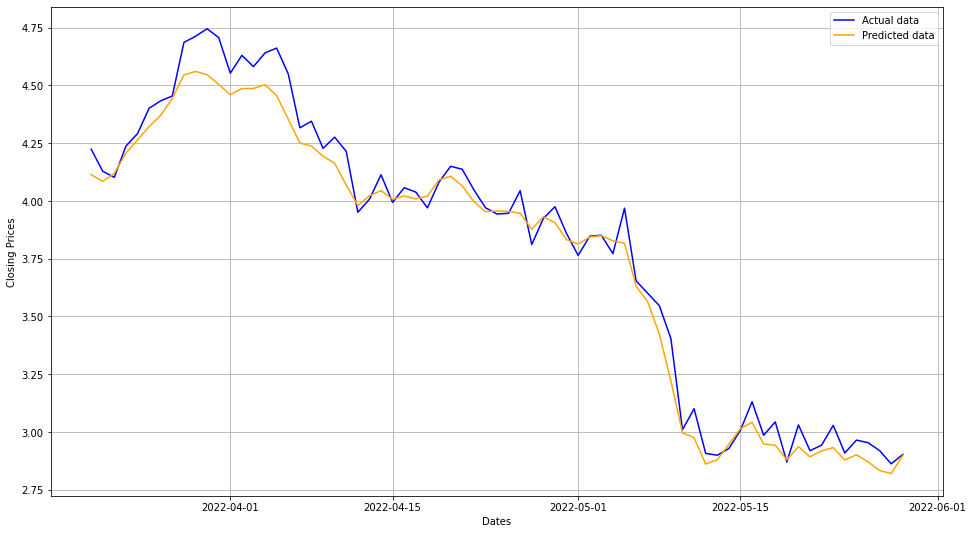

In [28]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [29]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.07
MAPE: 1.73%
MSE: 0.01
RMSE: 0.09
R2: -14.96


## Lấy 3 ngày cuối ra để dự báo

In [30]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -3.386201
2022-05-28   -3.450555
2022-05-29   -3.416818
Name: Error, dtype: float64

## Đưa về ma trận

In [31]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-3.38620122],
        [-3.45055472],
        [-3.41681823]]])

In [32]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-3.4724002], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [33]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.90271,6.319528,-3.416818


In [34]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.90271,6.319528,-3.416818,2.847128


## Ghi ra file csv

In [35]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")